# MA3315: Introduction to Visual Computing
## Assignment 1

This assignment has two problems. 

Let us load the required libraries first. 

In [3]:
from __future__ import print_function
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import sobel
import math
from scipy.signal import convolve2d
from scipy.sparse import lil_matrix



%matplotlib inline

## 1. The Canny edge detector 

For the first problem, we will implement our own Canny edge detector. Recall that the Canny edge detector consists of the following steps:
* Smoothing the image using a Gaussian filter
* Computing the gradient of the image&mdash;magnitude and direction&mdash;using the Sobel operator
* Non-maximum suppression using the gradient's magnitude and direction
* Double thresholding
* Edge connectivity using hysterisis

#### 1.A Smoothing

This standard smoothing operation can be implemented using the `gaussian_filter` function found in `sklearn.ndimage`. 
Alternatively, you can use the following Gaussian filter: 

`G = np.array([[2, 4,  5,  2,  2],
               [4, 9,  12, 9,  4],
               [5, 12, 15, 12, 5],
               [4, 9,  12, 9,  4],
               [2, 4,  5,  4,  2]]) / 156;`

#### 1.B Gradients

Use the Sobel operators to compute $g_x$ and $g_y$. The magnitude and direction of the gradient can be computed as 
$\sqrt{g_x^2 + g_y^2}$, and $\arctan\left(\frac{g_y}{g_x}\right)$

#### 1.C Non-maximum suppression

We will take a simplistic approach to non-maximum suppression. First, we quantise the gradient directions into four values&mdash;$0$, $\frac{\pi}{4}$, $\frac{\pi}{2}$, and $\frac{3\pi}{4}$. Next, we suppress gradients at all points that are not greater than the two neighbours found when moving in the direction perpendicular to the edge.

#### 1.D Doule thresholding

Double thresholding can be implemented by fixing two thresholds, `lo` and `hi`. Accordingly, we will have two *levels* of gradient magnitudes&mdash;*weak* and *strong*. Pixels where the magnitude of the gradient is greater than high will be designated *strong* points, while those where it lies between `lo` and `high` will be designated *weak*. 

Added info : on segmente en 3 sous-catégories, weak, medium, strong
Puis breadth first search(remplis la queue avec le sommet de départ, puis quand tu removes un tu ajoutes ses voisins à la queue et si la queue est vide et que tu as tout parcouru, tu n'as plus de possibilités pour atteindre B en partant de A donc voilà.
Queues

#### 1.E Edge connectivity

Finally, we decide on edge connectivity as follows: 
* All pixels with strong gradients belong to edges, termed *definite edges*.
* All pixels with weak gradients belong to edges only if they are connected to definite edges. 

Given below is a template for the Canny edge detector. Your task is to complete this function, and write any supporting functions necessary. You are, of course, free to diverge from this template, if you so wish. 

In [87]:

def gaussian_smoothing(image, intensity = 5):
    """
    We apply gaussian smooting to the image
    """
    
    return gaussian_filter(image,sigma=intensity)

def gradient(input_image):
    """Gradient Function.
    Inputs:
        input_image      The input image
    Outputs:
        g_magnitude      Magnitude of the gradient computed through Sobel operators.
        g_direction      Direction of the gradient computed through Sobel operators.
    """
    first_sobel_operator = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    second_sobel_operator = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
    g_x = convolve2d(input_image,first_sobel_operator, mode = "same", boundary = "symm")
    g_y = convolve2d(input_image,second_sobel_operator, mode = "same", boundary = "symm")
    
    return np.sqrt(g_x**2+g_y**2), np.arctan2(g_y,g_x)
    
    

def non_maximum_suppression(local_magnitude, local_direction):
    """
    We want to find the discrete directions of the local gradients.
    Therefore we project on the discrete directions and find the best one, then we determine if the points are the local maximum
    according to the given direction.
    We set the non maximum to zero and the others to their original value.
    
    Output : Matrix with non maximum points suppressed"""
    n = len(local_magnitude)
    m = len(local_magnitude[0]) #implies image cannot be empty
    details_matrix = np.zeros((n,m))
    
    list_direction = [0,math.pi/4,math.pi/2, 3*math.pi/4,math.pi,-math.pi/4,-math.pi/2, -3*math.pi/4,-math.pi]
    
    direction_dictionnary={0:"0",1:"pi/4",2:"pi/2",3:"3pi/4",4:"0",5:"3pi/4",6:"pi/2",7:"pi/4",8:"0"}
    
    for i in range(n):
        for j in range(m):
            pixel_direction = local_direction[i][j]
            pixel_intensity = local_magnitude[i][j]
            discrete_direction = direction_dictionnary[np.argmin([abs(pixel_direction-direction) for direction in list_direction])]

            try:
            
                if discrete_direction == "0":
                    right_neighbour =local_magnitude[i+1,j]
                    left_neighbour = local_magnitude[i-1,j]
                elif discrete_direction == "pi/4":
                    right_neighbour =local_magnitude[i+1,j+1]
                    left_neighbour = local_magnitude[i-1,j-1]
                elif discrete_direction == "pi/2":
                    right_neighbour =local_magnitude[i,j+1]
                    left_neighbour = local_magnitude[i,j-1]
                elif discrete_direction == "3pi/4":
                    right_neighbour =local_magnitude[i+1,j-1]
                    left_neighbour = local_magnitude[i-1,j+1]

                if (pixel_intensity >=right_neighbour) and (pixel_intensity>=left_neighbour):
                    details_matrix[i,j]=pixel_intensity
                    
            except IndexError:
                pass #So to say we set the border to 0. They cannot be edges in our model. We do not apply padding
                    #Because we are not really interested in this implementation in the borders. 

    return details_matrix  

def double_thresholding(intensity_matrix, first_threshold, second_threshold):
    """
    We then a two layers thresholding.
    """
    n = len(intensity_matrix)
    m = len(intensity_matrix[0])
    threshold_matrix = np.zeros((n,m))
    strong_points, weak_points = [], []
    for i in range(n):
        for j in range(m):
            if (first_threshold<=intensity_matrix[i][j])and( intensity_matrix[i][j]<second_threshold):
                weak_points.append([i,j])
                threshold_matrix[i][j]=1
            elif second_threshold<=intensity_matrix[i][j]:
                strong_points.append([i,j])
                threshold_matrix[i][j]=2
                
    return threshold_matrix

def connectivity(threshold_matrix):
    """
    The strong points previously determined are kept and all weak points connected to a strong one are kept.
    """
    for i in range(threshold_matrix.shape[0]) :
        for j in range(threshold_matrix.shape[1]) :
            if threshold_matrix[i,j] == 1:
                for x in range(i-3,i+3):
                    for y in range(j-3,j+3):
                        try :
                            if (x,y) != (i,j) and threshold_matrix[x,y] == 2 :
                                threshold_matrix[i,j] = 2
                        except IndexError:
                            pass
    return np.where(threshold_matrix == 2,1,0)


                
            
    
def canny_edge_detector(img, thresh_lo=15, thresh_hi=30):
    """
    The Canny edge detector.
    
    Inputs:
        img              The input image
        thresh_lo        The fraction of the maximum gradient magnitude which will 
                         be considered the lo threshold. 
        thresh_hi        The fraction of the maximum gradient magnitude which will
                         be considered the hi threshold. Ideally should be 2x to 3x 
                         thresh_lo.
                         
    Outputs: 
        edge_img         A binary image, with pixels lying on edges marked with a 1, 
                         and others with a 0.
    """
    
    # Smooth the image first. 
    smoothed             = gaussian_smoothing(img, intensity=4)
    
    # Find gradient magnitude and direction
    g_magnitude, g_dir   = gradient(smoothed)
    
    # Non-maximum suppression
    g_max                = non_maximum_suppression(g_magnitude, g_dir)
    
    # Double thresholding
    thresh_img           = double_thresholding(g_max, thresh_lo, thresh_hi)
    
    # Final edge connectivity
    edge_img             = connectivity(thresh_img)
    
    # Return the result
    return edge_img

Now test the code on a sample image&mdash;

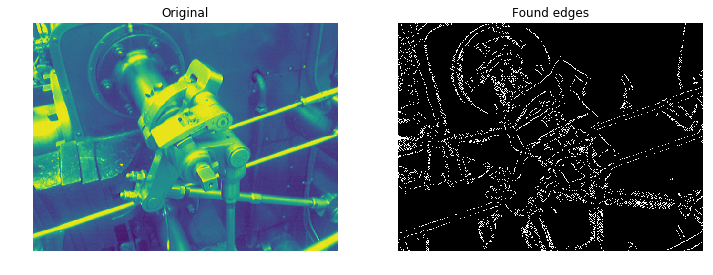

In [96]:
img   = cv2.imread('valve.png')
img   = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

edges = canny_edge_detector(img)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title('Original')

plt.subplot(1, 2, 2)
plt.imshow(edges,cmap = "gray")
plt.axis('off')
plt.title('Found edges')

plt.show()

## 2. Stitching two images

For this problem, you are given two images&mdash;`left.png` and `right.png`, which were extracted from a bigger image. All we know is that `left.png` lies to the left and a bit above of `right.png`, and there is an overlapping region between the two. Your task will be to *stitch* these images together so that you can form a bigger image out of two smaller images. 

Let us load the images first.

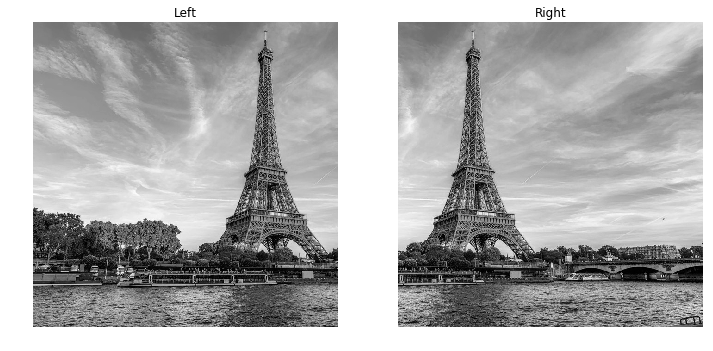

In [83]:
left_img   = cv2.imread('tour_eiffel_left.jpg')
# left_img   = cv2.imread('left.png')
left_img   = cv2.cvtColor(left_img, cv2.COLOR_RGB2GRAY)

right_img  = cv2.imread('tour_eiffel_right.jpg')
# right_img   = cv2.imread('right.png')
right_img  = cv2.cvtColor(right_img, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(left_img, cmap='gray')
plt.axis('off')
plt.title('Left')

plt.subplot(1, 2, 2)
plt.imshow(right_img, cmap='gray')
plt.axis('off')
plt.title('Right')

plt.show()

We will try to solve this problem using the Harris corner detector and the RANdom SAmple Consensus (RANSAC) algorithm. 

The steps are the following&mdash;
* Find corner points in both images using the Harris corner detector. 
* Choose a random pair of points&mdash;one from the left image, and the other from the right. 
* We will assume that this pair represents the same location in the scene in both images. This gives a translation vector, so the we can superimpose this point in the right image onto the left image.
* The translation gives us an overlapping region, which can be given a similarity score. 
* If we keep choosing this pair of points randomly, we can keep improving our similarity score until we have found the best match. 

Your task now is the complete the following code. 

In [96]:
def gradient_xy(input_image):
    """We compute in the same fashion as the first exercise the derivatives along x and y axis"""
    first_sobel_operator = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    second_sobel_operator = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
    g_x = convolve2d(input_image,first_sobel_operator, mode = "same", boundary = "symm")
    g_y = convolve2d(input_image,second_sobel_operator, mode = "same", boundary = "symm")
    return g_x, g_y

def compute_h(gx, gy):
    """We define h as a tensor of shape 2,2,shape of gx(same as gy)"""
    h = np.zeros((2, 2, *gx.shape))
    h[0, 0] = gx ** 2
    h[1, 1] = gy ** 2
    h[0, 1] = gx * gy
    h[1, 0] = h[1, 0]
    return h

def tensor_score(h, k):
    """We tried another formulation of the Harris score found in the litterature"""
    det = h[0, 0] * h[1, 1] - h[1, 0] * h[0, 1]
    trace = h[0, 0] + h[1, 1]
    r = det - k * trace ** 2
    #r = det/trace
    
    threshold = r.max()/100
    return np.where(r > threshold, 1, 0)

def non_maximum_suppression(image):
    """We want to keep only the local maximums in the created image"""
    
    corners = lil_matrix(image.shape)
    thresh = image.max()/50
    for (x,y) in zip(image.nonzero()[0],image.nonzero()[1]):
        x1 = max(x-2,0)
        y1 = max(y-2,0)
        
        if image[x,y] >= np.max(image[x1:x+3,y1:y+3]) and image[x,y]>thresh:
            corners[x,y] = 1

    return corners

def harris_corner_detector(img, k=0.04):
    """Let's compute the harris corner detection"""
    gx, gy = gradient_xy(img)
    h = compute_h(gx, gy)
    harris_image = tensor_score(h, k)
    return non_maximum_suppression(harris_image)
    
def find_random_pair(corners_left, corners_right):
    "Let's select points among the points detected"
    left_corners_number = corners_left.count_nonzero()
    right_corners_number = corners_right.count_nonzero()
    
    rand_left = np.random.randint(0,left_corners_number)
    rand_right = np.random.randint(0,right_corners_number)
    
    return ((corners_left.nonzero()[0][rand_left],corners_left.nonzero()[1][rand_left]),
            (corners_right.nonzero()[0][rand_right],corners_right.nonzero()[1][rand_right]))
    
def find_translation_vector(c_left, c_right):
    """Let's compute the translation vector"""
    return (c_right[0]-c_left[0],c_right[1]-c_left[1])

def compute_error(left, right, x_trans, y_trans):
    """The goal fo this function is to compute the error"""
    right = right.toarray()
    left = left.toarray()
    
    left_overlap_x_min = max(0, -x_trans)
    left_overlap_x_max = left.shape[0] - max(0, x_trans)
    
    right_overlap_x_min = max(0, x_trans)
    right_overlap_x_max = right.shape[0] - max(0, -x_trans)
    
    left_overlap_y_min = max(0, -y_trans)
    left_overlap_y_max = left.shape[1] - max(0, y_trans)
    
    right_overlap_y_min = max(0, y_trans)
    right_overlap_y_max = right.shape[1] - max(0, -y_trans)
    
    left_overlap = left[left_overlap_x_min:left_overlap_x_max-1,
                        left_overlap_y_min:left_overlap_y_max-1]
    right_overlap = right[right_overlap_x_min:right_overlap_x_max-1,
                          right_overlap_y_min:right_overlap_y_max-1]
        
    nb_common_points = 0
    for i in range(left_overlap.shape[0]):
        for j in range(left_overlap.shape[1]):
            nb_common_points += left_overlap[i,j]*right_overlap[i,j]
                
    if nb_common_points == 0:
        return np.inf
    return 1/nb_common_points

def stitch_images(left, right, max_tries=1000):
    """Let's stitch the images"""
    # Find corner points
    
    corners_left  = harris_corner_detector(left)
    corners_right = harris_corner_detector(right)    
    
    best_error = 255*left.shape[0]*left.shape[1]
    best_trans = None
    
    for n_try in range(max_tries):
        # Choose two points randomly
        c_left, c_right  = find_random_pair(corners_left, corners_right)

        # Get translation vector
        x_trans, y_trans = find_translation_vector(c_left, c_right)

        # Compute resulting error. 
        this_error       = compute_error(corners_left, corners_right, x_trans, y_trans)

        if this_error < best_error and x_trans*y_trans > 0:
            best_error   = this_error
            best_trans   = x_trans, y_trans
            
    stiched_image_shape = left.shape[0]+abs(best_trans[0]),left.shape[1]+abs(best_trans[1])
    stitched_image = np.zeros(stiched_image_shape)
    x_trans, y_trans =  best_trans

    try:
        stitched_image[:right.shape[0],:right.shape[1]] = right
        stitched_image[x_trans:,y_trans:] = left
        return stitched_image
    except : 
        print("Exception occured...")
        return stitch_images(left,right) #If we don't have x_trans and y_trans positives we just rerun the process.
    

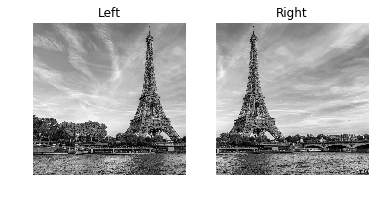

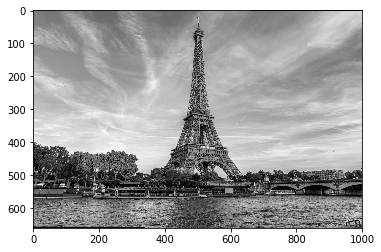

In [97]:
plt.subplot(1, 2, 1)
plt.imshow(left_img, cmap='gray')
plt.axis('off')
plt.title('Left')

plt.subplot(1, 2, 2)
plt.imshow(right_img, cmap='gray')
plt.axis('off')
plt.title('Right')

plt.show()

stitched = stitch_images(right_img, left_img, max_tries=2000)
plt.imshow(stitched,cmap="gray")
plt.show()

**Remark.** Note that in this simplified problem setting, we assumed only translations along $x-$ and $y-$axes. However, in a real-world scenario, we can expect any affine transformation and/or viewpoint differences between the two images. This means we can no longer decide correspondences using only one pair of points. Can you think of a strategy that can be employed in such a scenario? 

ANSWER : I guess we should still try this approach but we could induce a change in the coordinates system so that it adopts a new coordinate system which matches the required viewpoint. The types of transformations we could apply are translation, rotation, and scaling and combine all these effects to retrieve the projected viewpoint in which we can set some correspondences.